# Hierarchical Compression Analysis

This notebook demonstrates how hierarchical compression can achieve better compression ratios through repeated compression, even when compared to single compression with larger vocabularies.

We call the compression "HierarchicalLZCoder". Probably there is a better name.

We compare a bit with an "LZ" coder, which is just:
1. maintain a dictionary of prefixes.
2. look in the input for the shortest prefix that is NOT in the dictionary.
3. Add that prefix to the dictionary if the dictionary is less than the maximum dictionary size.
4. Output the index of the longest matching prefix (which might be the one just added), and remove it from the input stream.

Our approach just maintains a bunch of these LZ coder things in parallel, one for each possible output symbol. There is one other trick: when choosing which output symbol to associate with a newly-added prefix in one of the LZ coders, we ask all the *other* LZ coders that are not currently active what their best matching symbol is, and we choose the most popular available option.


### If you just want to see the plot, skip to the end


In [1]:
from src.lz import LZCoder, HierachicalLZCoder, ensure_list
import math
import matplotlib.pyplot as plt
import numpy as np

## Load Test Text

First, let's load our test text that we'll use for compression analysis. (I asked some LLM to write something for me...)

In [2]:
with open('test/compression_test_text.txt', 'r') as f:
    test_text = f.read().strip()

print(f"Text length: {len(test_text)} characters")
print("\nFirst 200 characters:")
print(test_text[:400] + "...")
print("total unique chars: ",len(set(test_text)))

Text length: 4776 characters

First 200 characters:
this is some awesome test here, I am really quite amazed. 
In particular, we are going to get some reasonable compression 
even though our encoding vocab size is only one more than the input vocab size!
Of course, this is not impossible because our encoding is context-dependent!
Even more amazingly would be if we could compress *twice* and get some reasonable compression!
That would indeed be the ...
total unique chars:  50


## Initial Compression

Let's perform the first level of compression using our hierarchical encoder.

In [3]:
# Convert text to list of bytes
to_encode_list = ensure_list(test_text)
input_vocab = set(to_encode_list)

# Create and apply first level compression
coder = HierachicalLZCoder(output_vocab_size=len(input_vocab), input_vocab=input_vocab)
encoded = coder.encode(to_encode_list, learn=True)

# Calculate bit length
encoded_length = len(encoded) * math.log(len(input_vocab)+1, 2)
original_length = len(to_encode_list) * math.log(len(set(encoded)), 2)

print(f"Original text length (bits): {original_length:.2f}")
print(f"First compression length (bits): {encoded_length:.2f}")
print(f"Compression ratio: {original_length/encoded_length:.2f}x")
print(f"\nFirst level vocabulary size: {len(input_vocab)}")
print(f"First level encoded vocabulary size: {len(set(encoded))}")

Original text length (bits): 27091.50
First compression length (bits): 15219.12
Compression ratio: 1.78x

First level vocabulary size: 50
First level encoded vocabulary size: 51


## Second Level Compression

Now let's compress the already compressed data with a larger vocabulary.

In [4]:
# Get vocabulary from first compression
encoded_vocab = set(encoded)

# Create and apply second level compression
second_coder = HierachicalLZCoder(output_vocab_size=2*len(encoded_vocab), input_vocab=encoded_vocab)
second_encoded = second_coder.encode(encoded, learn=True)

# Calculate bit length
second_encoded_length = len(second_encoded) * math.log(len(set(second_encoded)), 2)

print(f"Second compression length (bits): {second_encoded_length:.2f}")
print(f"Total compression ratio: {original_length/second_encoded_length:.2f}x")
print(f"\nSecond level vocabulary size: {len(encoded_vocab)}")
print(f"Second level encoded vocabulary size: {len(set(second_encoded))}")

Second compression length (bits): 11440.78
Total compression ratio: 2.37x

Second level vocabulary size: 51
Second level encoded vocabulary size: 52


## Comparison with Single Compression

Let's compare our results with a single compression using a larger vocabulary.

In [5]:
# Try single compression with double vocabulary
double_vocab_size = HierachicalLZCoder(output_vocab_size=2*len(input_vocab), input_vocab=input_vocab)
double_vocab_size_encoded = double_vocab_size.encode(to_encode_list, learn=True)
double_vocab_size_encoded_length = len(double_vocab_size_encoded) * math.log(len(set(double_vocab_size_encoded)), 2)

# Try LZ compression with large vocabulary
lz_coder = LZCoder(output_vocab_size=10*len(input_vocab)+1, input_vocab=input_vocab)
lz_encoded = lz_coder.encode(test_text, learn=True)
lz_encoded_length = len(lz_encoded) * math.log(len(set(lz_encoded)), 2)

print(f"Single compression with double vocabulary (bits): {double_vocab_size_encoded_length:.2f}")
print(f"LZ compression with 10x vocabulary (bits): {lz_encoded_length:.2f}")
print(f"\nDouble compression (bits): {second_encoded_length:.2f}")

Single compression with double vocabulary (bits): 15786.15
LZ compression with 10x vocabulary (bits): 18287.26

Double compression (bits): 11440.78


## Unconstrained LZ Compression

Let's see how the basic LZ coder performs when we don't limit its vocabulary size.

In [6]:
# Create LZ coder with unlimited vocabulary
unlimited_lz_coder = LZCoder(output_vocab_size=1000000, input_vocab=input_vocab)
unlimited_lz_encoded = unlimited_lz_coder.encode(test_text, learn=True)
unlimited_lz_encoded_length = len(unlimited_lz_encoded) * math.log(len(set(unlimited_lz_encoded)), 2)

print(f"Unlimited LZ compression length (bits): {unlimited_lz_encoded_length:.2f}")
print(f"Compression ratio: {original_length/unlimited_lz_encoded_length:.2f}x")
print(f"\nUnlimited LZ vocabulary size: {len(set(unlimited_lz_encoded))}")

Unlimited LZ compression length (bits): 15000.90
Compression ratio: 1.81x

Unlimited LZ vocabulary size: 1431


## Hierarchical Compression with Larger First Level

Let's try hierarchical compression starting with a larger vocabulary in the first level.

In [7]:
# Create first level coder with double vocabulary
double_first_coder = HierachicalLZCoder(output_vocab_size=2*len(input_vocab), input_vocab=input_vocab)
double_first_encoded = double_first_coder.encode(to_encode_list, learn=True)
double_first_encoded_length = len(double_first_encoded) * math.log(len(set(double_first_encoded)), 2)

# Get vocabulary from first compression
double_first_vocab = set(double_first_encoded)

# Create and apply second level compression
double_second_coder = HierachicalLZCoder(output_vocab_size=2*len(input_vocab), input_vocab=double_first_vocab)
double_second_encoded = double_second_coder.encode(double_first_encoded, learn=True)
double_second_encoded_length = len(double_second_encoded) * math.log(len(set(double_second_encoded)), 2)

print(f"First level with double vocabulary (bits): {double_first_encoded_length:.2f}")
print(f"Second level compression (bits): {double_second_encoded_length:.2f}")
print(f"Total compression ratio: {original_length/double_second_encoded_length:.2f}x")
print(f"\nFirst level vocabulary size: {len(double_first_vocab)}")
print(f"Second level vocabulary size: {len(set(double_second_encoded))}")
print("two input vocab", 2*len(input_vocab))

First level with double vocabulary (bits): 15786.15
Second level compression (bits): 13621.82
Total compression ratio: 1.99x

First level vocabulary size: 53
Second level vocabulary size: 54
two input vocab 100


## LZ First Level with Hierarchical Second Level

Let's explore using LZ compression for the first level, followed by hierarchical compression.

In [8]:
# First level LZ compression
lz_first_coder = LZCoder(output_vocab_size=10*len(input_vocab)+1, input_vocab=input_vocab)
lz_first_encoded = lz_first_coder.encode(to_encode_list, learn=True)
lz_first_encoded_length = len(lz_first_encoded) * math.log(len(set(lz_first_encoded)), 2)

# Get vocabulary from LZ compression
lz_first_vocab = set(lz_first_encoded)

# Create and apply hierarchical second level compression
lz_second_coder = HierachicalLZCoder(output_vocab_size=max(2*len(input_vocab), len(lz_first_vocab)), input_vocab=lz_first_vocab)
lz_second_encoded = lz_second_coder.encode(lz_first_encoded, learn=True)
lz_second_encoded_length = len(lz_second_encoded) * math.log(len(set(lz_second_encoded)), 2)

print(f"LZ first level compression (bits): {lz_first_encoded_length:.2f}")
print(f"Hierarchical second level (bits): {lz_second_encoded_length:.2f}")
print(f"Total compression ratio: {original_length/lz_second_encoded_length:.2f}x")
print(f"\nLZ first level vocabulary size: {len(lz_first_vocab)}")
print(f"Second level vocabulary size: {len(set(lz_second_encoded))}")

LZ first level compression (bits): 18287.26
Hierarchical second level (bits): 15508.89
Total compression ratio: 1.75x

LZ first level vocabulary size: 489
Second level vocabulary size: 489


In [9]:
# First level LZ compression 2x vocab
lz_first_coder_2x = LZCoder(output_vocab_size=2*len(input_vocab)+1, input_vocab=input_vocab)
lz_first_encoded_2x = lz_first_coder_2x.encode(test_text, learn=True)
lz_first_encoded_length_2x = len(lz_first_encoded_2x) * math.log(len(set(lz_first_encoded_2x)), 2)

# Get vocabulary from LZ compression
lz_first_vocab_2x = set(lz_first_encoded_2x)

# Create and apply hierarchical second level compression, keep vocab the same, so still 2x
lz_second_coder_2x = HierachicalLZCoder(output_vocab_size=2*len(input_vocab), input_vocab=lz_first_vocab_2x)
lz_second_encoded_2x = lz_second_coder_2x.encode(lz_first_encoded_2x, learn=True)
lz_second_encoded_length_2x = len(lz_second_encoded_2x) * math.log(len(set(lz_second_encoded_2x)), 2)

print(f"LZ first level compression (bits): {lz_first_encoded_length_2x:.2f}")
print(f"Hierarchical second level (bits): {lz_second_encoded_length_2x:.2f}")
print(f"Total compression ratio: {original_length/lz_second_encoded_length_2x:.2f}x")
print(f"\nLZ first level vocabulary size: {len(lz_first_vocab_2x)}")
print(f"Second level vocabulary size: {len(set(lz_second_encoded_2x))}")

LZ first level compression (bits): 24309.85
Hierarchical second level (bits): 15659.57
Total compression ratio: 1.73x

LZ first level vocabulary size: 99
Second level vocabulary size: 100


## Visualization

Let's make a visualization of all compression methods.

Plot Legend Info: N x vocab indicates that the encoding dictionary has size ~N x the input alphabet.
                  A + B indicates we first compress with method A, then apply method B
                  HLZ is the 'hierarchical' method, LZ is the regular method


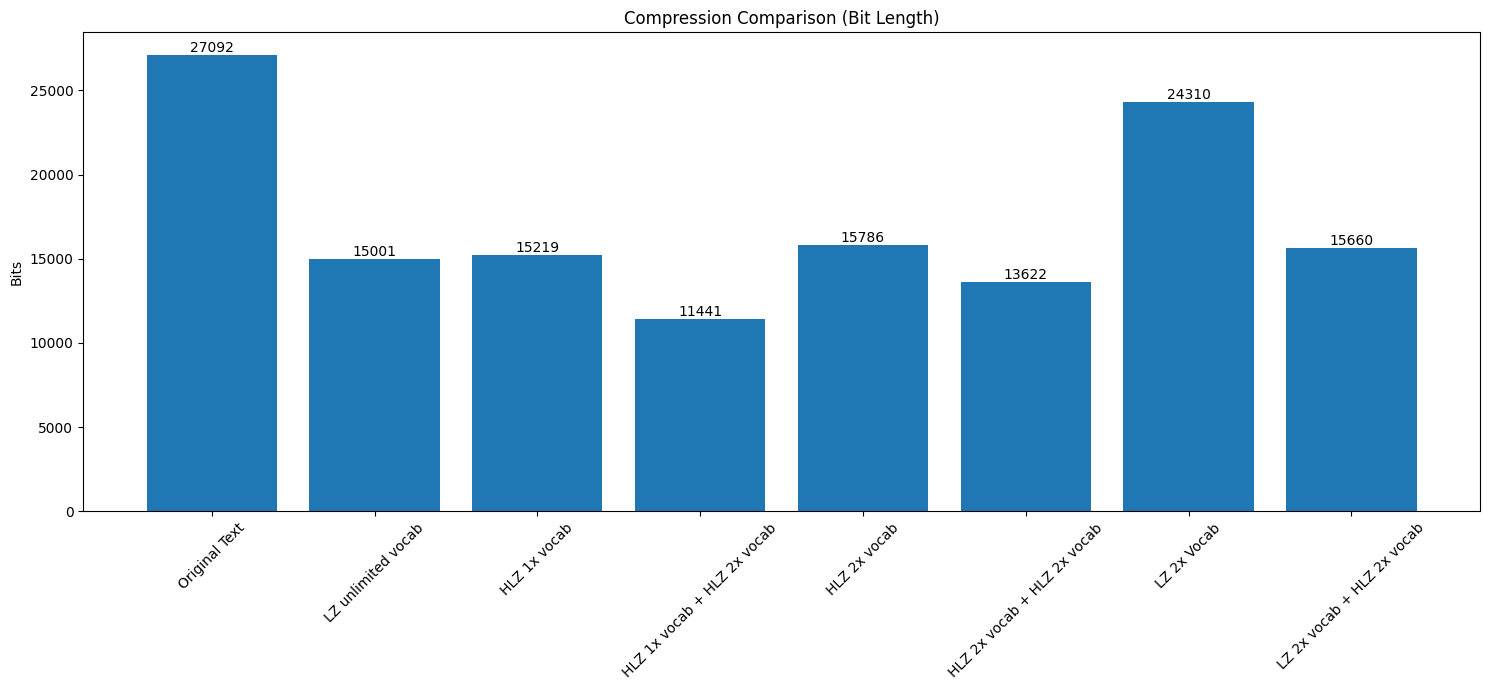


Compression Ratios:
Original Text: 1.00x
LZ unlimited vocab: 1.81x
HLZ 1x vocab: 1.78x
HLZ 1x vocab + HLZ 2x vocab: 2.37x
HLZ 2x vocab: 1.72x
HLZ 2x vocab + HLZ 2x vocab: 1.99x
LZ 2x Vocab: 1.11x
LZ 2x vocab + HLZ 2x vocab: 1.73x


In [10]:
# Prepare data for plotting
from collections import OrderedDict

methods_and_lengths = OrderedDict([
    ('Original Text', original_length),
    ('LZ unlimited vocab', unlimited_lz_encoded_length),
    ('HLZ 1x vocab', encoded_length),
    ('HLZ 1x vocab + HLZ 2x vocab', second_encoded_length),
    ('HLZ 2x vocab', double_vocab_size_encoded_length),
    ('HLZ 2x vocab + HLZ 2x vocab', double_second_encoded_length),
    # ('LZ 10x Vocab', lz_encoded_length),
    # ('LZ 10x vocab + HLZ 10x vocab', lz_second_encoded_length),
    ('LZ 2x Vocab', lz_first_encoded_length_2x),
    ('LZ 2x vocab + HLZ 2x vocab', lz_second_encoded_length_2x),
])

methods = methods_and_lengths.keys()
bit_lengths = methods_and_lengths.values()

# Create bar plot
plt.figure(figsize=(15, 7))
bars = plt.bar(methods, bit_lengths)
plt.title('Compression Comparison (Bit Length)')
plt.ylabel('Bits')
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}',
             ha='center', va='bottom')

plt.tight_layout()
print("Plot Legend Info: N x vocab indicates that the encoding dictionary has size ~N x the input alphabet.")
print("                  A + B indicates we first compress with method A, then apply method B")
print("                  HLZ is the 'hierarchical' method, LZ is the regular method")
plt.show()

# Calculate and display compression ratios
ratios = [original_length/l for l in bit_lengths]
print("\nCompression Ratios:")
for method, ratio in zip(methods, ratios):
    print(f"{method}: {ratio:.2f}x")

## Extended Analysis

The additional experiments reveal:
1. Even with an unlimited vocabulary, the basic LZ coder doesn't achieve the same compression as hierarchical methods
2. Starting with a larger vocabulary in the first level of hierarchical compression seems worse (which makes sense: it probably takes more data to find statistics with a larger vocabulary)
3. Using LZ compression as the first level followed by hierarchical compression seeems slightly worse
4. The hierarchical approach seems to possibly work when composed with itself, but not with LZ.